In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mlforecast import MLForecast

# from mlforecast.sklearn import SklearnForecast
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

In [17]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [18]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [19]:
df_brl.head()

,ds,y,unique_id
0,2020-01-01,73.428636,ACUCAR_SANTOS
1,2020-02-01,81.636111,ACUCAR_SANTOS
2,2020-03-01,79.906364,ACUCAR_SANTOS
3,2020-04-01,77.113500,ACUCAR_SANTOS
4,2020-05-01,84.638500,ACUCAR_SANTOS


In [20]:
train, val, test = split_series(df_brl)

Splitted data into TRAIN with size 1605, VALIDATION with size 406 and TEST with size 868


In [6]:
model_lgbm = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=10,
    num_leaves=63,
    min_child_samples=5,
    reg_alpha=0,
    reg_lambda=0.01,
    random_state=42
)

fcst = MLForecast(
    models={'lgmb': model_lgbm},
    lags=[1, 2],
    freq='MS'
)

In [7]:
# start tunning here if needed eventually

In [8]:
full_train = pd.concat([train, val])

In [9]:
fcst.fit(full_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 2
[LightGBM] [Info] Start training from score 192.230433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

MLForecast(models=[lgmb], freq=MS, lag_features=['lag1', 'lag2'], date_features=[], num_threads=1)

In [10]:
# Rollout
forecasts = []
for i in range(len(test)):
    f_next = fcst.predict(h=1)
    forecasts.append(f_next)

    # add real value
    obs = test.iloc[[i]][['unique_id', 'ds', 'y']]
    fcst.update(obs)

In [11]:
forecasts_df = pd.concat(forecasts, ignore_index=True)

In [12]:
evaluator = MetricEvaluator()

In [13]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['lgbm'],         
    groupby_column='unique_id'     
)

print(results)

Empty DataFrame
Columns: []
Index: []


In [14]:
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)

KeyError: 'Model'

KeyError: 'lgbm'

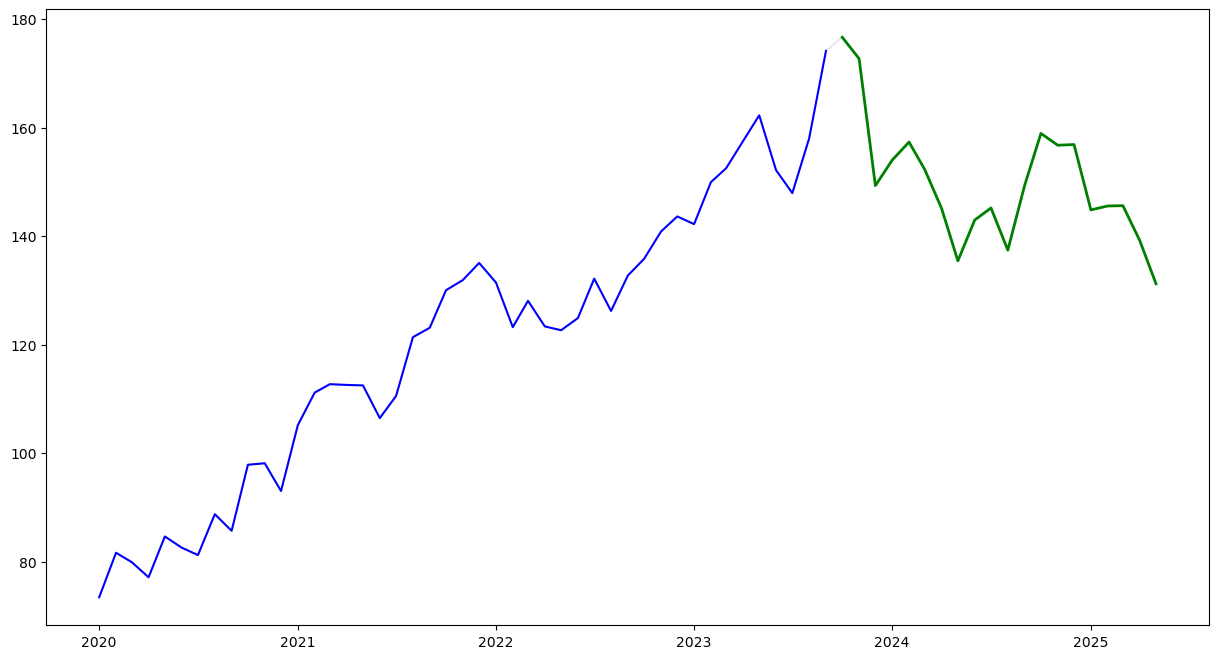

In [15]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    """
    Plota a série completa e as previsões para cada commodity individualmente
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lightgray', alpha=0.7, linewidth=1, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='blue', linewidth=1.5, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='green', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['lgbm'], 
                color='red', linewidth=2, linestyle='--', label='Previsão LGBM')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)

In [21]:
model = GradientBoostingRegressor(
    n_estimators=1000, 
    max_depth=10,
    learning_rate=0.1, min_samples_leaf=5
)

fcst = MLForecast(
    models={'gmb': model},
    lags=[1, 2],
    freq='MS'
)

In [22]:
# start tunning here if needed eventually

In [23]:
full_train = pd.concat([train, val])

In [24]:
fcst.fit(full_train)

MLForecast(models=[gmb], freq=MS, lag_features=['lag1', 'lag2'], date_features=[], num_threads=1)

In [25]:
# Rollout
forecasts = []
for i in range(len(test)):
    f_next = fcst.predict(h=1)
    forecasts.append(f_next)

    # add real value
    obs = test.iloc[[i]][['unique_id', 'ds', 'y']]
    fcst.update(obs)

In [26]:
forecasts_df = pd.concat(forecasts, ignore_index=True)

In [27]:
evaluator = MetricEvaluator()

In [28]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['gbm'],         
    groupby_column='unique_id'     
)

print(results)

Empty DataFrame
Columns: []
Index: []


In [29]:
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)

KeyError: 'Model'

KeyError: 'gbm'

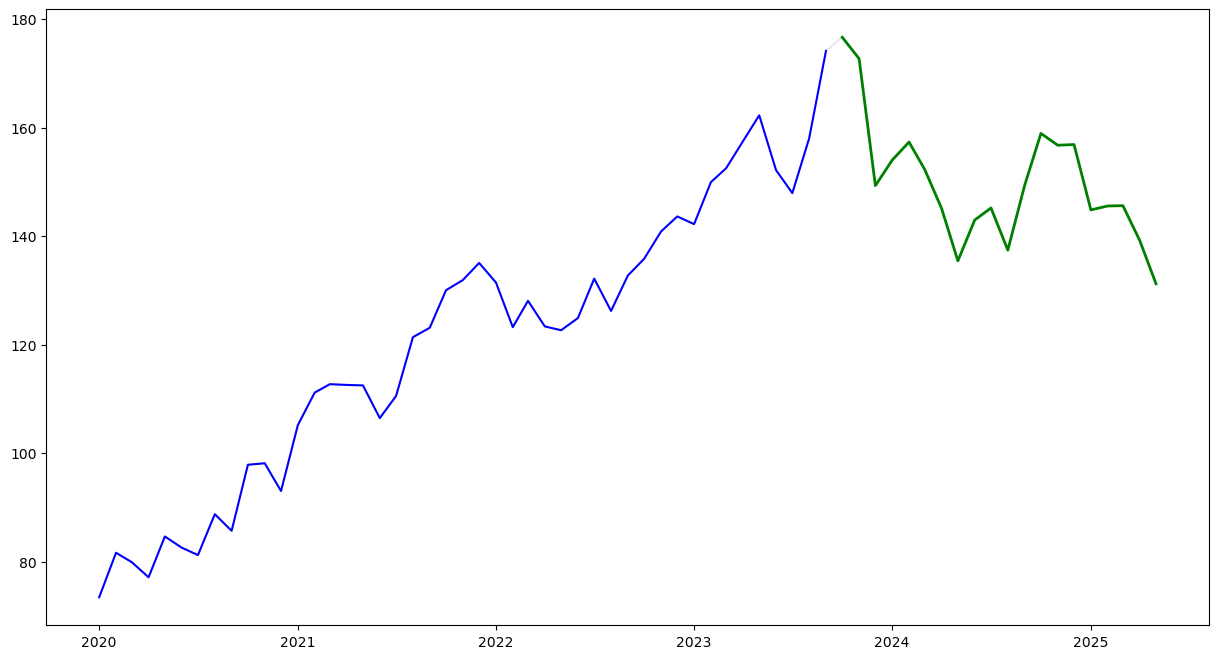

In [30]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    """
    Plota a série completa e as previsões para cada commodity individualmente
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lightgray', alpha=0.7, linewidth=1, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='blue', linewidth=1.5, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='green', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['gbm'], 
                color='red', linewidth=2, linestyle='--', label='Previsão GBM')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)